**решающее дерево**

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
# import itertools
from time import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

##  загружаем данные 

In [2]:
# data = [
#     np.loadtxt('../data/200_2b/points_1.txt'),
#     np.loadtxt('../data/200_2b/points_2.txt') 
# ]

In [3]:
# data = [
#     np.loadtxt('../data/399_4/points_b.txt'),
#     np.loadtxt('../data/399_4/points_g.txt'),
#     np.loadtxt('../data/399_4/points_r.txt'),
#     np.loadtxt('../data/399_4/points_y.txt'),
# ]

In [4]:
# "бананы"
# data = [
#     np.loadtxt('../data/6402_2/points_1.txt'),
#     np.loadtxt('../data/6402_2/points_2.txt')
# ]

In [5]:
data = [
    np.loadtxt('../data/1998_2/points_b.txt'),
    np.loadtxt('../data/1998_2/points_r.txt')    
]

---

In [6]:
# собираем вместе
X = np.vstack(data)
n_cls = len(data) # количество классов

In [8]:
# метки классов
y = [ [i]*data[i].shape[0] for i in range(n_cls)]
y = np.asarray(sum(y,[]))

X.shape, y.shape

((1998, 2), (1998,))

In [9]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=get_seed() )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((999, 2), (999,), (999, 2), (999,))

In [11]:
%xdel X
%xdel y

---

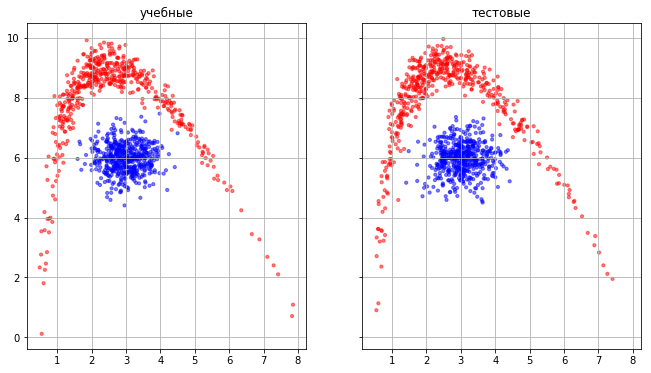

In [12]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,6),)
    
axarr[0].set_title('учебные')
axarr[0].scatter( x=X_train[:,0], 
                  y=X_train[:,1], 
                  c=[['b','r','g','y'][j] for j in y_train ],  
                  s=10,
                  alpha=0.5 )
axarr[0].grid()

axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], 
                  y=X_test[:,1], 
                  c=[ ['b','r','g','y'][j] for j in y_test],
                  s=10,
                  alpha=0.5 )
axarr[1].grid()

plt.show()

---

Алгоритм обучения выглядит следующим образом.

1. если X содержит точки только одного класса то переход на п.6

2. выбрать признак номер $i$ и найти для него пороговое значение $b$, $(min(X_i) < b < max(X_i) )$ с максимальной информативностью разделения

3. сохранить найденную пару $(i,b)$

4. разделить $X$ на две части по признаку $i$ и его порогу $b$

5. выполнить рекурсивно с п.1 для каждого полученного на пред.шаге подмножества

6. конец работы

---

In [13]:
class Node:
    def __init__(self, feature=-1, bound=0, mark=-1, left=None, right=None):
        self._feature = feature
        self._bound = bound
        self._mark = mark
        self._left = left
        self._right = right
        
    @property
    def feature(self): return self._feature

    @property
    def bound(self): return self._bound
    
    @property
    def mark(self): return self._mark
    
    @property
    def left(self): return self._left
    
    @property
    def right(self): return self._right
    
#     @mark.setter
#     def mark(self,value): self._mark = value
    
#     @left.setter
#     def left(self,value): self._left = value
    
#     @right.setter
#     def right(self,value): self._right = value
    
    def __repr__(self): return '%i:%f'%(self.feature, self.bound)

In [14]:
def h(q):
    q = min(0.999, max(1e-9,q))
    return -q*np.log2(q) - (1.0-q)*np.log2(1.0-q)

def igain(s,p_y,p,n):
    # разница в информативности, 
    # до и после примения предиката
    
    # s - количество примеров
    # p_y - количество положительных
    # p - количество положительных примеров, выделенных предикатом   
    # n - количество отрицательных примеров, выделенных предикатом
    
    return h(p_y/s) - ( (p+n)/s * h(p/(p+n)) + (s-p-n)/s * h( (p_y-p)/(s-p-n)) )

def info(X,y,b):
    s = len(y) #  количество примеров
    p_y = y.sum() # количество положительных
    
    f = X>b #  отмечаем примеры выделенные предикатом 
    p = y[f].sum() # количество положительных примеров, выделенных предикатом   
    n = -(y[~f]-1).sum() # количество отрицательных примеров, выделенных предикатом
    
    return igain(s,p_y,p,n) # разница в информативности

In [15]:
def search_split(X,y,nb=30):
    # nb = 30 # количество порогов (частей при разбиении отрезка) 

    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] for i in range(X.shape[1]) ])

    # изменение информативности для разных признаков и значений порогов 
    inf = np.array([ 
        [ info(X[:,i],y,b[i,j]) for i in range(X.shape[1])  ] 
        for j in range(b.shape[1]) 
    ])

    # параметры с максимальным значением информативности
    j,i = np.unravel_index(inf.argmax(),inf.shape)

    return i,b[i,j]

In [48]:
def build_dtree(X,y,max_deep=0,nb=50,deep=0):
    # если разбиение содержит точки одного класса
    if (y==1).all() or (y==0).all(): 
        return Node(mark=y[0]) # то создаём лист с меткой класса
    
    if (max_deep<deep)and(max_deep>0): # глубина дерева ограничена
        # большая часть множества имеет такие метки
        mark = int(y.sum()>(len(y)//2))
        return Node(mark=mark) 
    
    # ищем оптимальное разделение по признаку
    i,b = search_split(X,y,nb)

    # повторяем рекурсивно для двух подмножеств
    f = X[:,i]>b    
    tl = build_dtree(X[f,:], y[f],max_deep=max_deep,deep=deep+1) 
    tr = build_dtree(X[~f,:], y[~f],max_deep=max_deep,deep=deep+1)
    
    # добавляем узел дерева
    return Node(feature=i, bound=b, left=tl, right=tr)    



In [63]:
%%time

dtree = build_dtree(X_train,y_train,nb=10,max_deep=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


CPU times: user 5.88 s, sys: 14 ms, total: 5.9 s
Wall time: 6.06 s


In [64]:
def split_subset(X,p,Xpos,Xneg):
    if(p.left is None): 
        if p.mark > 0: 
            Xpos.append(X)
        else:
            Xneg.append(X)
        return [Xpos,Xneg]

    f = X[:,p.feature]>p.bound
    
    XposL,XnegL = split_subset(X[f,:],p.left,Xpos,Xneg)
    XposR,XnegR = split_subset(X[~f,:],p.right,Xpos,Xneg)

    return [XposL+XposR,XnegL+XnegR]


def split_data(X,p):
    Xpos,Xneg = split_subset(X,p,[],[])
    Xpos = np.vstack(Xpos)
    Xneg = np.vstack(Xneg)
    return Xpos,Xneg


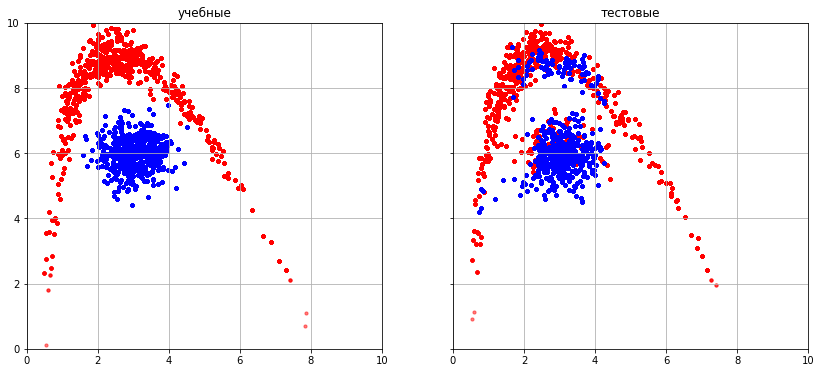

In [68]:
f, axarr = plt.subplots( 1, 2, sharey=True, sharex=True, figsize=(14,6),)

Xpos,Xneg = split_data(X_train,dtree)
axarr[0].set_title('учебные')
axarr[0].scatter(x=Xpos[:,0],y=Xpos[:,1],s=10,c='r',alpha=0.5)
axarr[0].scatter(x=Xneg[:,0],y=Xneg[:,1],s=10,c='b',alpha=0.5)
axarr[0].set_xlim([0,10])
axarr[0].set_ylim([0,10])
axarr[0].grid()

Xpos,Xneg = split_data(X_test,dtree)
axarr[1].set_title('тестовые')
axarr[1].scatter(x=Xpos[:,0],y=Xpos[:,1],s=10,c='r',alpha=0.5)
axarr[1].scatter(x=Xneg[:,0],y=Xneg[:,1],s=10,c='b',alpha=0.5)
axarr[1].grid()

plt.show()

---

In [21]:
# tree = Node(1,0.23)

# tree.left = Node(2,0.4)

# print(tree.left)